In [37]:
# Import libraries
import pandas as pd
from ast import literal_eval
from itertools import chain
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from statistics import mode

In [2]:
# Load data with keeping structures inside data frame
songs = pd.read_csv('lyrics_processed_data.csv', converters={'Tokenized Lyrics': literal_eval, 'Lemmatized Words': literal_eval, 'Parts of Speech': literal_eval, 'Adjectives': literal_eval, 'Nouns': literal_eval, 'Adverbs': literal_eval, 'Pronouns': literal_eval, 'Verbs': literal_eval,})
display(songs)

,Position,Artist,Song Title,Year,JSON file,Split Names,Song Language,Lyrics,Tokenized Lyrics,Lemmatized Words,Parts of Speech,Adjectives,Nouns,Adverbs,Pronouns,Verbs
0,1,Gordon Jenkins and The Weavers,Goodnight Irene,1950,0.json,Gordon Jenkins,en,irene goodnight irene goodnight goodnight iren...,"[irene, goodnight, irene, goodnight, goodnight...","[irene, goodnight, irene, goodnight, goodnight...","[(irene, NN), (goodnight, VBD), (irene, JJ), (...","[irene, goodnight, last, saturday, i, gon, ire...","[irene, goodnight, irene, irene, i, dream, nig...","[down, now, sometimes, sometimes, sometimes, l...","[you, me, me, you, you, you, you]","[see, take, see, jump, see, stop, stop, stop, ..."
1,2,Nat King Cole,Mona Lisa,1950,1.json,Nat King Cole,en,"mona lisa, mona lisa, men have named you you'r...","[mona, lisa, ,, mona, lisa, ,, men, have, name...","[mona, lisa, ,, mona, lisa, ,, men, have, name...","[(mona, NN), (lisa, NN), (,, ,), (mona, NN), (...","[mystic, broken, many, warm, real, cold, lovel...","[mona, lisa, mona, lisa, lady, smile, mona, st...","[so, only, lonely, just, there, just, lonely, ...","[you, you, it, you, they, you, you, they, they...","[smile, tempt, hide, lie, mona, smile, tempt, ..."
2,4,Gary and Bing Crosby,Sam's Song,1950,3.json,Gary,en,"ah, here's a happy tune, you'll love to croon ...","[ah, ,, here, 's, a, happy, tune, ,, you, 'll,...","[ah, ,, here, 's, a, happy, tune, ,, you, 'll,...","[(ah, NN), (,, ,), (here, RB), ('s, VBZ), (a, ...","[happy, grim, grand, wrong, happy, happy, litt...","[ah, tune, song, melody, sam, song, nothing, m...","[here, then, only, soon, so, never, here, real...","[you, they, it, sam, it, they, it, you, you, i...","[love, croon, call, be, get, do, agree, forget..."
3,5,Gary and Bing Crosby,Simple Melody,1950,4.json,Gary,en,won't you play some simple melody like my moth...,"[wo, n't, you, play, some, simple, melody, lik...","[wo, n't, you, play, some, simple, melody, lik...","[(wo, MD), (n't, RB), (you, PRP), (play, VB), ...","[simple, good, old, simple, musical, classical...","[melody, mother, sang, harmony, melody, demon,...","[n't, n't, just, simply, na, n't, just, simply...","[you, me, you, me, you, you, you, me, you, you...","[play, play, set, play, play, get, rag, set, p..."
4,6,Teresa Brewer,"Music, Music, Music",1950,5.json,Teresa Brewer,en,put another nickel in in the nickelodeon all i...,"[put, another, nickel, in, in, the, nickelodeo...","[put, another, nickel, in, in, the, nickelodeo...","[(put, VB), (another, DT), (nickel, NN), (in, ...","[danciong, danciong, old]","[nickel, nickelodeon, i, music, music, music, ...","[close, so, close, so]","[you, you, you, me, you, you, me, you, you, yo...","[put, do, want, come, do, want, come, keep]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6297,96,Morgan Wallen,More Than My Hometown,2020,6675.json,Morgan Wallen,en,"girl, our mamas are best friends and so are we...","[girl, ,, our, mamas, are, best, friends, and,...","[girl, ,, our, mama, are, best, friend, and, s...","[(girl, NN), (,, ,), (our, PRP$), (mama, NN), ...","[whole, likely, few, real, deep, real, u, brig...","[girl, mama, friend, town, rooting, u, home, t...","[so, n't, n't, just, n't, yet, baby, n't, n't,...","[we, 'em, we, you, you, you, you, you, you, yo...","[settle, let, grow, stop, blame, go, i, need, ..."
6298,97,Luke Combs,Lovin' On You,2020,6676.json,Luke Combs,en,don't get me wrong i like a bobber on the wate...,"[do, n't, get, me, wrong, i, like, a, bobber, ...","[do, n't, get, me, wrong, i, like, a, bobber, ...","[(do, VBP), (n't, RB), (get, VB), (me, PRP), (...","[wrong, friday, dunn, strong, i, right, two-do...","[bobber, water, hookin, reelin, i, night, ride...","[n't, again, soon, n't, enough, back, soon, n'...","[me, 'em, it, me, you, you, you, you, you, you...","[get, slow, hit, get, get, get]"
6299,98,Moneybagg Yo,Said Sum,2020,6677.json,Moneybagg Yo,en,"(turn me up, yc) huh? (what?) ah, i thought a ...","[(, turn, me, u

<AxesSubplot:title={'center':"Count received songs' lyrics per year"}, xlabel='Year'>

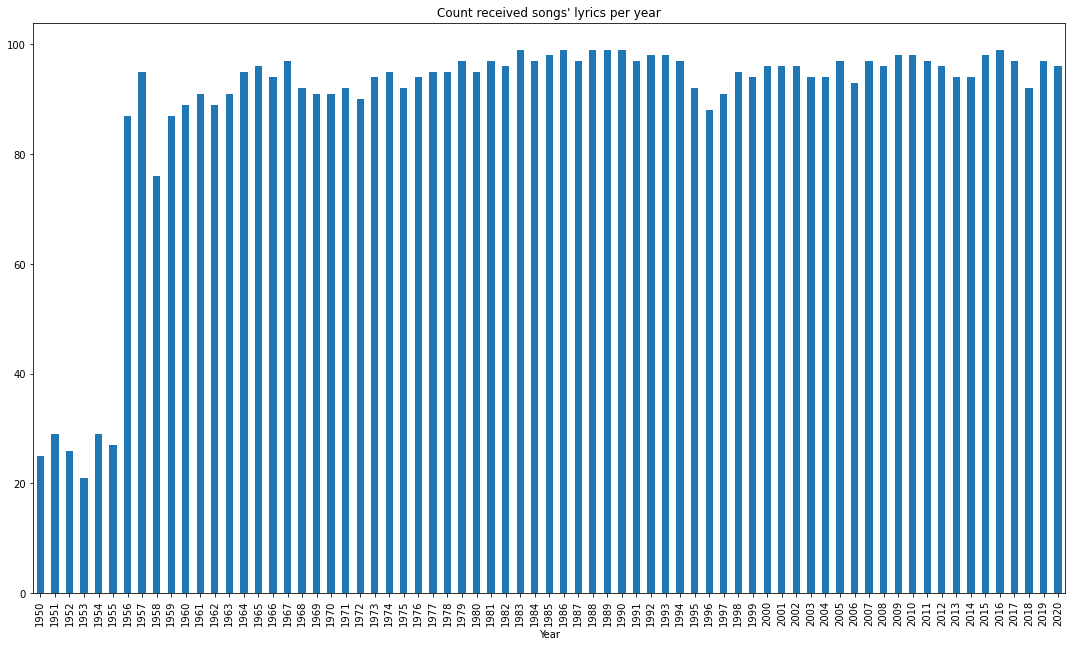

In [3]:
# Count received songs' lyrics per year
songs.groupby('Year').count().plot(y = 'Song Title', kind = 'bar', figsize = (18.5, 10.5), legend = False, title = 'Count received songs\' lyrics per year')

<AxesSubplot:xlabel='Year'>

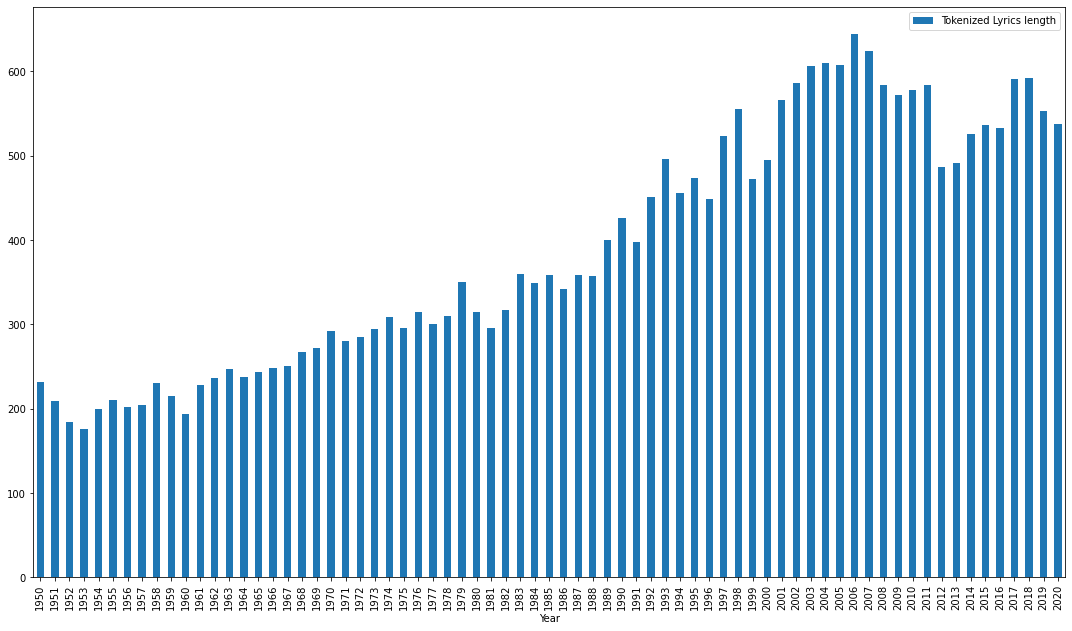

In [4]:
# Mean word count
songs['Tokenized Lyrics length'] = songs['Tokenized Lyrics'].str.len()
songs.groupby('Year').mean('Tokenized Lyrics length').plot(y = 'Tokenized Lyrics length', kind = 'bar', figsize = (18.5, 10.5))

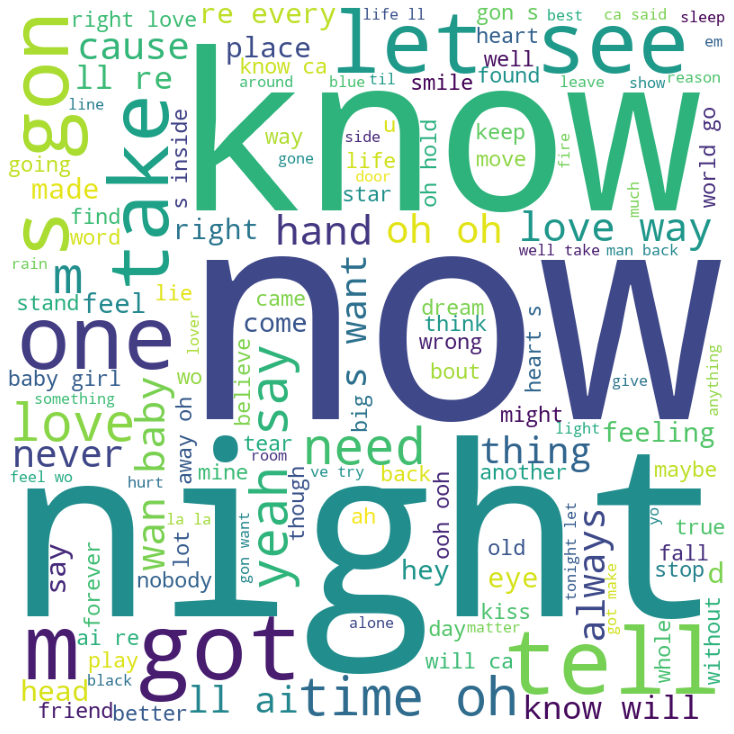

In [5]:
# Word cloud
set_lyrics = [set(i) for i in songs['Tokenized Lyrics']]
set_lyrics = list(chain(*set_lyrics))
join_lyrics = (" ").join(set_lyrics)

STOPWORDS.add('n\'t')

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = STOPWORDS, min_font_size = 15).generate(join_lyrics)
plt.figure(figsize = (18.5, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [38]:
# The most popular word each year
most_popular_word_per_year = pd.DataFrame({'Year':list(range(1950, 2021))})
lyrics_per_year = []

# Function for converting lists to sets
def lists_to_sets(l):
    return [{i for i in row} for row in l]

# Combination of lyrics per year
for i in list(songs['Year'].unique()):
    song_lyrics = songs['Tokenized Lyrics'][songs['Year'] == i].to_list()
    set_song_lyrics = lists_to_sets(song_lyrics)
    flat_song_lyrics = [item for i in set_song_lyrics for item in i]
    lyrics_per_year.append(flat_song_lyrics)
    
# Set for every song in particular year
most_popular_word_per_year['Combined Lyrics'] = lyrics_per_year

most_popular_word_per_year['Most Popular Word'] = [mode(i) for i in most_popular_word_per_year['Combined Lyrics']]

display(most_popular_word_per_year)

,Year,Combined Lyrics,Most Popular Word
0,1950,"[parted, another, jump, me, a, to, family, ram...",and
1,1951,"['ve, try, this, really, love, of, to, a, thou...",and
2,1952,"[this, precious, wheel, of, way, sigh, me, a, ...",you
3,1953,"[this, 've, lips, pretending, wo, me, is, to, ...",to
4,1954,"[rely, is, say, we, forever, room, gray, i, cr...",in
...,...,...,...
66,2016,"[mama, fell, them, all, felt, movin, i, walls,...",i
67,2017,"[sour, thrifty, is, magnet, one, say, all, we,...",","
68,2018,"[mama, party, this, weston, into, is, southsid...",","
69,2019,"[matte, ride, 'til, is, ), yeah, all, tractor,...",the
